<a href="https://colab.research.google.com/github/SahanaDil/UCSD-deep-neural-networks/blob/main/Adaptive_Algorithms_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Algorithms in Neural Networks

In this project, we'll implement several adaptive optimizers to improve the performance in the descent algorithm.

The following instructions are identified as Steps in the text cells preceding their corresponding code cell. Read through the instructions and write/fill-in the appropriate code in the cells.

Note, you will need the base classes (Layer, Dense, Model) from the DNN framework that you updated in the previous assignment. You may reuse your previous code as needed.  

You'll also need the imports, plot functions and dataset generation code from the previous assignments.


In [1]:
import numpy as np

import h5py
import matplotlib.pyplot as plt
import math

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


## The Framework
Implement the Layer, Dense, and Model classes you wrote and tested in the previous units.  

**Step 1:**  

Recreate the Layer class.
Note, the new argument "train_or_test" has been included in the Layer constructor to let you specify if you are training or testing.   

<br>
Note, this code is the same as in the previous assignment.

In [88]:
class Layer:

  def __init__(self, output_units, input_units, activation,initialization, train_or_test):

    self.learning_rate = 0.01

    if initialization == 'he':
      self.weights = np.random.randn(output_units, input_units) * np.sqrt((2/input_units))
    if initialization == 'random':
      self.weights = np.random.randn(output_units, input_units) * 0.01

    self.biases = np.zeros((output_units,1))

    self.activation = activation


  #Sigmoid activation:
  def sigmoid(self, Z):
    Z = np.clip(Z, -500, 500)
    return 1 / (1 + np.exp(-Z))

  #ReLu activation:  return the activation of Z applied to the ReLu function
  def relu(self, Z):
    return np.maximum(0,Z)

  #Tanh activation:  return the activation of Z applied to the tanh function
  #Note, use the numpy tanh function here
  def tanh(self, Z):
    return np.tanh(Z)

  # Backward activations
  # Computes the derivatives of activation functions.
  def activation_backwards(self,Z, dA):
    # Check the activation function then calc the activiation gradient
    #       (e.g. sigmoid_grad, relu_grad, tanh_grad)
    #Sigmoid
    if self.activation == 'sigmoid':
      sigmoid= 1/(1 + np.exp(-Z))
      grad = sigmoid * (1-sigmoid)
      return dA * grad

    elif self.activation == 'relu':
      grad = np.where(Z > 0, 1, 0)
      return dA * grad

    elif self.activation == 'tanh':
      tanh = np.tanh(Z)
      grad = 1 - tanh ** 2
      return dA * grad




  #Abstract methods - will complete in child classes
  def forward(self, X, train_or_test):
      self.X = X
      self.Z = np.dot(self.weights, X) + self.biases
      if self.activation == 'sigmoid':
        self.A = self.sigmoid(self.Z)
      elif self.activation == 'relu':
        self.A = self.relu(self.Z)
      elif self.activation == 'tanh':
        self.A = self.tanh(self.Z)

      return self.A

  def backward(self, dA, optimizer, i):
      m = self.X.shape[0]
      dZ = self.activation_backwards(self.Z, dA)
      self.dW = np.dot(self.X.T, dZ) / m
      self.db = np.sum(dZ, axis=0)/m
      dX = np.dot(dZ, self.W.T)
      return dX

  def update(self, learning_rate, optimizer):
      self.weights -= self.learning_rate * self.dW
      self.biases -= self.learning_rate * self.db

**Step 2:**  
Recreate the Dense class from the previous units You will need the constructor(), forward(), backward(), and update() methods.  
<br>
**Momentum:**  
For the first algorithm, momentum, we’ll need to initialize V_dW, V_db, and beta (which we’ve called beta1). Since V_dW and V_db are simply matrices containing exponential moving averages (or EMAs) for each parameter in the model, they should be the same shape as the weights and biases matrices. This means you can use the numpy function 'np.zeros()' to initialize V_dW with the same shape as the weights matrix, and use 'np.zeros()' to initialize V_db with the same shape as the biases matrix. Initialize beta1 to 0.9.  
<br>
**backward():**   
- Navigate to the backward() function. We previously modified this function to also take as arguments the optimizer (a string), and the iteration number. You can see that we calculate dW and db as usual.  First, notice that we increment the iteration by 1. This is because in our iteration ‘for’ loop in the fit() method, we loop from 0 to the number of total epochs. For bias correction purposes, it will work much better to think of the first epoch as epoch 1 rather than epoch 0, so we increase the value of i by 1. This helps us avoid division by zero.
- Next, we can start working on the first conditional block. Modify the first if statement to check if the optimizer is the string ‘momentum’.  You can then calculate V_dW and V_db as was discussed on the lecture video by coding the appropriate equations, and store them as instance variables.   
  - $V_{dW}=\beta_1\cdot V_{dW}+(1-\beta_1)\cdot dW$
  - $V_{db}=\beta_1\cdot V_{db}+(1-\beta_1)\cdot db$

Remember when using beta1 in  you calculations that it is an instance variable so you will need to use ‘self.beta1’

- The next step is to implement bias correction. We want the bias corrected value of V_dW, which we’ll call V_dW_corr  
  - $V_{dWcorr}=\frac{V_{dW}}{\sqrt{1-\beta_1^{\text{ } iteration}}}$,  where ’t’ is the iteration number.   

- Do the same for V_db_corr using V_db.   
  - $V_{dbcorr}=\frac{V_{db}}{\sqrt{1-\beta_1^{\text{ } iteration}}}$


**update():**  
- Now that we have bias corrected value of V_dW and V_db, we can move on to the update() function. Use an if statement to check if the optimizer is ‘momentum’.   
- Then, implement the update steps as we discussed in the lecture video, but use the bias corrected values.  For example, you should update the weights with self.weights:  
  - $W=W-\alpha\cdot V_{dWcorr}$    
  - $b=b-\alpha\cdot V_{dbcorr}$  

Note, you can leave the code commented for RMSprop and Adam as-is for now.  You will fill the details for those optimizers in a later step.   

Don’t forget that once you have completed your additions to the Dense class, you’ll need to rerun the Dense class cell and Model class cell to activate the changes for use in the subsequent code.



In [89]:
class Dense(Layer):

  # Inherit from the Layer class.
  def __init__(self, output_units, input_units, activation, initialization='he', train_or_test='train'):
    super().__init__(output_units, input_units, activation, initialization, train_or_test)

    # Initialize moving averages and hyperparameter values.
    self.V_dW = np.zeros_like(self.weights)
    self.V_db = np.zeros_like(self.biases)
    self.beta1 = 0.9
    self.S_dW = np.zeros_like(self.weights)
    self.S_db = np.zeros_like(self.biases)
    self.beta2 = 0.999
    self.epsilon = 1e-8


  # Forward step for a single layer.
  def forward(self, input, train_or_test):
    self.input = input
    Z = np.dot(self.weights, self.input) + self.biases
    self.Z = Z

    if self.activation == "sigmoid":
      A = self.sigmoid(Z)

    elif self.activation == "relu":
      A = self.relu(Z)

    elif self.activation == 'tanh':
      A = self.tanh(Z)

    self.A = A

    assert (self.Z.shape == (self.weights.shape[0], self.A.shape[1]))
    assert (self.A.shape == (self.weights.shape[0], self.input.shape[1]))

    return A


  # Backward step for a single layer.
  def backward(self, dA_prev, optimizer, iteration):
    dZ = self.activation_backwards(self.Z, dA_prev)
    m = self.input.shape[1]
    self.dW = (1 / m) * np.dot(dZ, self.input.T)
    self.db = (1 / m) * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(self.weights.T, dZ)


    # Iteration counter.
    iteration += 1

    # Compute V_dW and V_db using momentum.
    if optimizer == 'momentum':
      self.V_dW = self.beta1 * self.V_dW + (1-self.beta1) * self.dW
      self.V_db = self.beta1 * self.V_db + (1-self.beta1) * self.db

      # Calculate the bias corrected values of V_dW and V_db.
      self.V_dW_corr = self.V_dW/(1-self.beta1**iteration)
      self.V_db_corr = self.V_db/(1-self.beta1**iteration)

    # Calculate S_dW and S_db for RMSprop.
    elif optimizer == 'RMSprop':
      self.S_dW = self.beta2 * self.S_dW + (1 - self.beta2) * (self.dW ** 2)
      self.S_db = self.beta2 * self.S_db + (1 - self.beta2) * (self.db ** 2)

      # Calculate the bias corrected values of S_dW and S_db.
      self.S_dW_corr = self.S_dW/(1-self.beta2**iteration)
      self.S_db_corr = self.S_db/(1-self.beta2**iteration)

    # Calculate V_dW, V_db, S_dW, and S_db for Adam.
    elif optimizer == 'Adam':
      self.V_dW = self.beta1 * self.V_dW + (1-self.beta1) * self.dW
      self.V_db = self.beta1 * self.V_db + (1-self.beta1) * self.db
      self.S_dW = self.beta2 * self.S_dW + (1 - self.beta2) * (self.dW ** 2)
      self.S_db = self.beta2 * self.S_db + (1 - self.beta2) * (self.db ** 2)


      # Bias correct the values.
      self.V_dW_corr = self.V_dW/(1-self.beta1**iteration)
      self.V_db_corr = self.V_db/(1-self.beta1**iteration)
      self.S_dW_corr = self.S_dW/(1-self.beta2**iteration)
      self.S_db_corr = self.S_db/(1-self.beta2**iteration)


    assert (dA_prev.shape == self.input.shape)
    assert (self.dW.shape == self.weights.shape)
    assert (self.db.shape == self.biases.shape)

    return dA_prev

  # Parameter update for a single layer.
  def update(self, learning_rate, optimizer):

    if optimizer == 'gradient descent':
      self.weights = self.weights - learning_rate*self.dW
      self.biases = self.biases - learning_rate*self.db


    # For momentum, update the parameters using the bias corrected values of V_dW and V_db.
    elif optimizer == 'momentum':
      self.weights = self.weights - learning_rate * self.V_dW_corr
      self.biases = self.biases - learning_rate * self.V_db_corr


    # For RMSprop, update the weights using the bias corrected values of S_dW and S_db.
    elif optimizer == 'RMSprop':
      self.weights -= learning_rate * self.dW / (np.sqrt(self.S_dW_corr)+self.epsilon)
      self.biases -= learning_rate * self.db / (np.sqrt(self.S_db_corr)+self.epsilon)

    # For Adam, update the weights using the bias corrected values of V_dW, V_db, S_dW, and S_db.
    elif optimizer == 'Adam':
      self.weights -= learning_rate * self.V_dW_corr / (np.sqrt(self.S_dW_corr)+self.epsilon)
      self.biases -= learning_rate * self.V_db_corr / (np.sqrt(self.S_db_corr)+self.epsilon)


**Step 3:**  
Recreate the Model class.  You will need the constructor and the following methods:

- build()
- feedforward()
- compute_cost()
- backpropagation()
- parameter_update()
- train()
- fit()
- predict()
- evaluate()  

<br>
Note, this code is the same as the previous assignment with the addition of a new method.


**Step 4:**  
Add a new method, make_minibatch()   
First, we shuffle the data (see #1 in the code template).  This is important as it makes each minibatch more likely to be representative of the overall distribution.   
Next, we partition the data into batches of size “mini batch size” (see #2 in the code template).  For example, if we partition our training dataset into 90 examples, this means with a batch_size of 16, we’ll have 5 full mini-batches, and then one left over containing only 10 examples.    Here, we want to iterate over the number of minibatches.  You can see that we are using multidimensional array slicing to index from the “kth” example to the example indexed by “k + batch_size”.  This then completes a minibatch.    
Then, we need to process the special case for the final minibatch.  This minibatch should take the leftover examples and put them into a minibatch.


**Step 5:**  
Next, let’s look at the” fit” function. Here, you can see now that we need a “for loop” over the minibatches.
We can do this by iterating through the list of minibatches for X and Y, since the “make_minibatch” function returns a list of tuples.
Inside the “for loop”, you can perform batch descent as normal, except this time using the size of the minibatch as “m”.
Essentially you would treat each minibatch as an entire training set and perform descent on it.
However, since the minibatches will be much smaller than the overall training set, this means you will be taking more steps per epoch and convergence will happen faster.
Typically, we create minibatches of size n where n is a power of 2, since this is convenient for CPU and GPU implementations and storage.
You’ll therefore often see and use minibatches of size 16, 32, 64, or some other power of 2.



**Step 6:**  
Finally, we also need to recreate the plot() method from the previous assignment used to plot the training costs.  


In [90]:
class Model:

  def __init__(self):
    self.epsilon = 1e-8

  def build(self, network):
    self.network = network

  # Forward propagation.
  def feedforward(self, X, train_or_test):

    # Set the input to X.
    input = X

    # Loop over the layers and call the forward method on each input.
    for l in self.network:
      input = l.forward(input, train_or_test) # We pass train_or_test here to specify if this is training or test time.

    # Set AL to the final value of input (i.e. the output of the final layer).
    AL = input
    assert (AL.shape == (1, X.shape[1]))

    return AL

  # Compute cost - remember to call np.squeeze().
  def compute_cost(self, m, AL, Y):
    cost = (-1 / m) * np.sum(Y * np.log(AL + self.epsilon) + (1 - Y) * np.log(1 - AL + self.epsilon))
    cost = np.squeeze(cost)

    return cost


  # Backpropagate through  layers.
  def backpropagation(self, dAL, optimizer, i):

    # Set dA_prev to dAL.
    dA_prev = dAL

    # Loop over the layers in reverse and call the backward method on each dA_prev.
    for l in reversed(self.network):
      # We pass the optimizer and iteration here so we can compute the backprop steps.
      dA_prev = l.backward(dA_prev, optimizer,i)


  # Parameter update.
  def parameter_update(self, learning_rate, optimizer):

    # Loop over layers and call the update method from each.
    for l in self.network:
      l.update(learning_rate, optimizer)

    ### END CODE HERE ###

  # Sinlge iteration of descent.
  def train(self, X, Y, learning_rate, optimizer, i):

    # Extract number of example from the shape of Y.
    m = Y.shape[1]

    # Compute AL by running forward propagation.
    AL = self.feedforward(X, train_or_test='train')

    # Cost calculation.
    cost = self.compute_cost(m, AL, Y)

    Y = Y.reshape(AL.shape)

    # Initialize backpropagation by calculating dAL.
    dAL = - (np.divide(Y, (AL + self.epsilon)) - np.divide(1 - Y, (1 - AL + self.epsilon)))

    # Backpropagate through layers.
    self.backpropagation(dAL, optimizer, i)

    # Update parameters.
    self.parameter_update(learning_rate, optimizer)

    return cost


  # Function for training loop.
  def fit(self, X_train, Y_train, epochs, learning_rate, batch_size, optimizer='gradient descent', verbose=False, callback=None):

    # Initialize list of costs.
    costs = []

    # Make minibatches from the input data.
    mini_batches_train = self.make_minibatch(X_train, Y_train, batch_size)

    # Loop over epochs.
    for i in range(epochs):

      # Loop over minibatches.
      for mini_batch_X, mini_batch_Y in mini_batches_train:

        # Call the train method and append the cost to the list. Remember to pass the optimizer and iteration number to train().
        cost = self.train(mini_batch_X, mini_batch_Y, learning_rate, optimizer, i)
        # Append the iteration and cost to the list as a tuple.
        costs.append((i, cost))

      if (i % 50 == 0):
        if verbose==True:
          print ("Iteration: {}, cost: {}". format(i, cost))

        if (callback is not None):
          callback(i, X_train, Y_train)

    return costs


  # Predict labels.
  def predict(self, X):

    # Get the predictions (output of the final layer after training). Remember to specify that this is test time.
    predictions = self.feedforward(X, train_or_test='test')

    # Set predictions to either 0 or 1.
    predictions = np.where(predictions > 0.5, 1, 0)
    return predictions

  # Evaluate prediction accuracy.
  def evaluate(self, predictions, Y):

    # calculate accuracy.
    accuracy = (100 - np.mean(np.abs(predictions - Y)) * 100)

    return accuracy


  # Batching function
  def make_minibatch(self, X, Y, mini_batch_size):

    # To make your "random" minibatches the same each time.
    np.random.seed(0)  #Do not change, for grading purposes

    m = X.shape[1]

    # List of minibatches.
    mini_batches = []

    # 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):

      mini_batch_X = shuffled_X[:, (k * mini_batch_size) : ((k + 1) * mini_batch_size)]
      mini_batch_Y = shuffled_Y[:, (k * mini_batch_size) : ((k + 1) * mini_batch_size)]

      mini_batch = (mini_batch_X, mini_batch_Y)
      mini_batches.append(mini_batch)

    # 3. Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

      mini_batch_X = shuffled_X[:, (mini_batch_size * math.floor((m / mini_batch_size))) : m]
      mini_batch_Y = shuffled_Y[:, (mini_batch_size * math.floor((m / mini_batch_size))) : m]

      mini_batch = (mini_batch_X, mini_batch_Y)
      mini_batches.append(mini_batch)

    return mini_batches

In [91]:
# Use matplotlib to plot the costs (same as previous assignment).

def plot(costs):
  # Use *zip() to plot the list of tuples of (iteration, cost).
  iterations, cost_values = zip(*costs)

  plt.plot(iterations, cost_values)
  plt.xlabel("Iteration")
  plt.ylabel("Cost")
  plt.title("Training cost over iteration")

  return plt

## Planar Data
**Step 7:**  
Now we’re going to recap how to build a model and train it on data.
In our project, we’re going to be working with a binary classification planar dataset like the one we used previously.
However, this dataset will be a little harder to classify, since we only have 100 examples, and the dataset is relatively noisy.
Run the code provided to create the dataset, and then call the “make plot” function as you did in the previous unit to see the dataset visualized.  This planar dataset could represent any labelled data that is describable in two dimensions – for instance,  x and y coordinates of the location from where a basketball shot was made, and the label (that is the color of the data point)  representing whether or not the shot went in.
This makes our model widely applicable to a range of problems. Once you have plotted the dataset, run the reshaping cell and then call “see shapes”.
You should see that we have a 90-10% train –test split.

Run the "Reshaping" cell then check the shapes of the train and test dataset to see more information about your data. You should see the following shapes:

- X_train shape: (2, 90)
- Y_train shape: (1, 90)
- X_test shape: (2, 10)
- Y_test shape: (1, 10)  

Each example has two features (that is, the x and y coordinates in the plane) and one label (that is, the color of the point).


In [52]:
# number of samples in the data set
N_SAMPLES = 100

# Load the data and split into a train and test set.
X, Y = make_moons(n_samples = N_SAMPLES, noise=0.5, random_state=100)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [53]:
# The function to graph the dataset (same as previous assignment)

def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

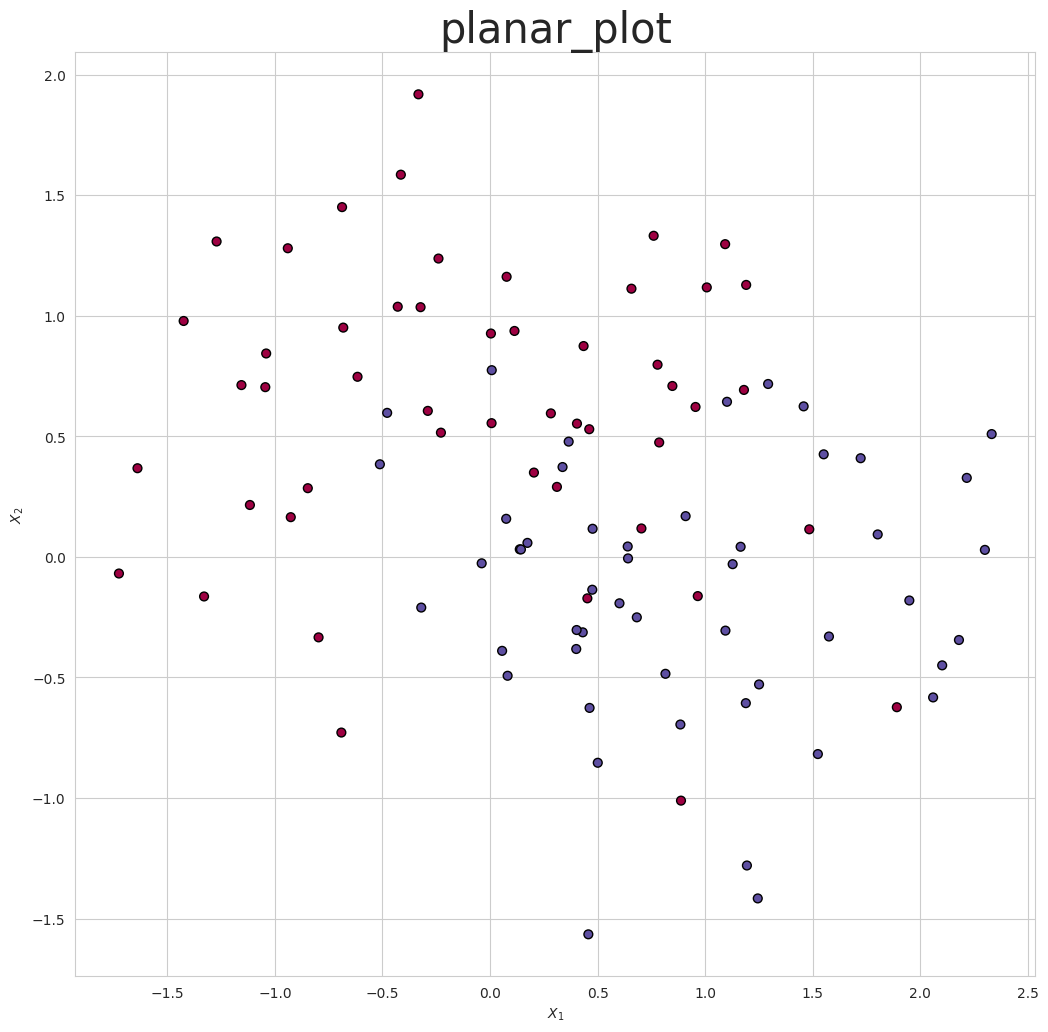

In [54]:
# Call make_plot (pass X, Y, and the name of the plot only).
make_plot(X, Y, 'planar_plot')


In [55]:
# Reshaping.
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.reshape(1, Y_train.shape[0])
Y_test = Y_test.reshape(1, Y_test.shape[0])


import doctest

'''
  >>> print(X_train.shape)
  (2, 90)
  >>> print(X_test.shape)
  (2, 10)
  >>> print(Y_train.shape)
  (1, 90)
  >>> print(Y_test.shape)
  (1, 10)
'''

doctest.testmod()

TestResults(failed=0, attempted=4)

## Optimization Algorithms

### Momentum

Now it is time to test your model.  
<br>
**Step 8:**  

Instantiate your model and build it with the same network architecture as before. That is construct the model with 2 inputs nodes, which is equal to the shape of the planar dataset, Dense layers of 25, 50, 50, and 25 nodes each, and an output layer of 1 node. Set each layer’s activation function to ‘relu’ except for the output layer, which should be set to ‘sigmoid’.

We’re going to use all of our new algorithms in conjunction with ‘minibatch descent’. As such, when fitting your model to the data, use 50,000 epochs, a learning_rate of 0.001, a batch size of 16, and set the optimizer to ‘momentum’. Run the training, plot the costs, make predictions, and evaluate your train and test accuracy.

In [58]:
# Instantiate your model.
momentum_model = Model()

# Build a deep neural network.
momentum_model.build([
                  Dense(output_units=25, input_units=2, activation='relu'),
                  Dense(output_units=50, input_units=25, activation='relu'),
                  Dense(output_units=50, input_units=50, activation='relu'),
                  Dense(output_units=25, input_units=50, activation='relu'),
                  Dense(output_units=1, input_units=25, activation='sigmoid'),
])


**Step 9:**

We’re going to use all of our new algorithms in conjunction with ‘minibatch descent’.
As such, when fitting your model to the data, use 50,000 epochs, a learning_rate of 0.001, a batch size of 16, and set the optimizer to ‘momentum’.  Run the training, plot the costs, make predictions, and evaluate your train and test accuracy.

In [59]:
# Use the momentum algorithm by setting the optimizer to 'momentum'. Set the batch size to 16.
# Fit your model to the training data with 50000 epochs and a learning_rate of 0.001.
costs = momentum_model.fit(X_train, Y_train, epochs=50000, learning_rate=0.001, batch_size=16, optimizer='momentum')


**Steps 10-13:**  
Plot your costs and take a look at the graph. You should see that in comparison to regular minibatch descent, descent with momentum converges more quickly and trains with lower variance cost estimates. You can see this from the smaller blue area in the graph for momentum as compared to minibatch descent.
Finally, run your predictions for the train and test sets, and evaluate the accuracy of each.

**********************************************************************
File "__main__", line 3, in __main__
Failed example:
    print(np.round(costs[0][1], 3))
Expected:
    0.811
Got:
    0.69
**********************************************************************
File "__main__", line 5, in __main__
Failed example:
    print(np.round(costs[1500][1], 3))
Expected:
    0.425
Got:
    0.426
**********************************************************************
File "__main__", line 7, in __main__
Failed example:
    print(np.round(costs[3500][1], 3))
Expected:
    0.215
Got:
    0.217
**********************************************************************
File "__main__", line 9, in __main__
Failed example:
    print(np.round(costs[15000][1], 3))
Expected:
    0.386
Got:
    0.397
**********************************************************************
File "__main__", line 11, in __main__
Failed example:
    print(np.round(costs[32000][1], 3))
Expected:
    0.2
Got:
    0.198
*************

TestResults(failed=8, attempted=8)

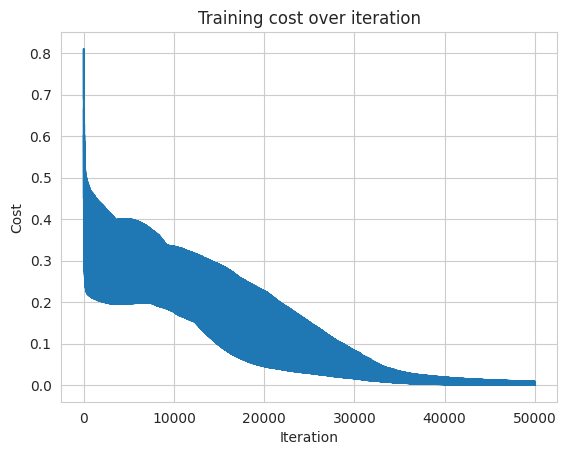

In [60]:
# Plot the costs.
plot(costs)



# 100 samples / 16 batch size = 6.25 samples per batch
# 6 samples per epoch * 50000 epochs = 300000 costs
import doctest

"""
  >>> print(np.round(costs[0][1], 3))
  0.811
  >>> print(np.round(costs[1500][1], 3))
  0.425
  >>> print(np.round(costs[3500][1], 3))
  0.215
  >>> print(np.round(costs[15000][1], 3))
  0.386
  >>> print(np.round(costs[32000][1], 3))
  0.2
  >>> print(np.round(costs[75000][1], 3))
  0.259
  >>> print(np.round(costs[150000][1], 3))
  0.032
  >>> print(np.round(costs[299999][1], 3))
  0.0
"""

doctest.testmod()

In [61]:
# Get predictions on the train set.
predictions_train = momentum_model.predict(X_train)

# Get predictions on the test set.
predictions_test = momentum_model.predict(X_test)



import doctest

"""
  >>> print(predictions_train[0][17])
  1
  >>> print(predictions_train[0][50])
  1
  >>> print(predictions_test[0][1])
  0
  >>> print(predictions_test[0][6])
  0
"""

doctest.testmod()

**********************************************************************
File "__main__", line 7, in __main__
Failed example:
    print(predictions_test[0][1])
Expected:
    0
Got:
    1
**********************************************************************
1 items had failures:
   1 of   4 in __main__
***Test Failed*** 1 failures.


TestResults(failed=1, attempted=4)

In [62]:
# Evaluate train accuracy.
momentum_model.evaluate(predictions_train, Y_train)



import doctest

"""
  >>> print(np.round(momentum_model.evaluate(predictions_train, Y_train), 3))
  100.0
"""

doctest.testmod()

TestResults(failed=0, attempted=1)

In [63]:
# Evaluate test accuracy.
momentum_model.evaluate(predictions_test, Y_test)



import doctest

"""
  >>> print(np.round(momentum_model.evaluate(predictions_test, Y_test), 3))
  90.0
"""

doctest.testmod()

**********************************************************************
File "__main__", line 3, in __main__
Failed example:
    print(np.round(momentum_model.evaluate(predictions_test, Y_test), 3))
Expected:
    90.0
Got:
    70.0
**********************************************************************
1 items had failures:
   1 of   1 in __main__
***Test Failed*** 1 failures.


TestResults(failed=1, attempted=1)

### RMSprop

As discussed in the lecture videos, we’re going to consider the y direction to be our unwanted direction and the x direction to be our desired direction in which we must move to reach the minimum point.
We’ve represented the cost function in 2 dimensions here; and for our deep neural network model, the x and y axes could be rewritten as the weights ‘W’  and biases ‘B’ axes respectively, since the cost ‘J’ is a function of ‘W’ and ‘B’.
However, recall when working with a deep model we typically have many features or independent variables which are represented as nodes in the input layer,  and as a result our cost function is very high dimensional.
We want to move from our starting point in the descent to the destination point, which should simply be a horizontal line in our conceptual model.   
Therefore, we only want to change the desired parameters affecting that dimension and not any others. This in practice means we want to minimize any movement in the vertical axis, which we can set to be all other parameters.  Please refer to the lecture video for more details on this conceptual description.

Now we’re ready to understand RMSprop. RMSprop is similar to momentum but has a couple of key differences.
Let’s take a look at the RMSprop algorithm. On iteration t, we compute dW and db for the current mini-batch, in the same way as regular batch descent and momentum. However, instead of taking a regular EMA, we’re going to instead alter the calculation slightly. Instead of V_dW and V_db, we’re going to use S_dW and S_db. We’re also going to call our weighting hyperparameter beta2 to differentiate it from the beta1 we used in momentum (this will be helpful later on).
The difference is that we are going to compute the EMA of the squares of dW and db respectively.
- $S_{dW}=\beta_2\cdot S_{dW}+(1-\beta_2)\cdot dW^2$
- $S_{db}=\beta_2\cdot S_{db}+(1-\beta_2)\cdot db^2$

Next, comes the key step. We’re going to update W using:   
- $W=W-\alpha\cdot \frac{dW}{\sqrt{S_{dW}}}$

and b using:   
- $b=b-\alpha\cdot \frac{db}{\sqrt{S_{db}}}$

We want learning to happen quickly in the desired direction, which means making large updates to a specific set of parameters. We also want learning to happen slowly in the undesired direction, which means making small updates to another set of parameters.
Now, how does RMSprop help us do this? Let’s look at S_dW and S_db:  
- $S_{dW}=\beta_2\cdot S_{dW}+(1-\beta_2)\cdot dW^2$
- $S_{db}=\beta_2\cdot S_{db}+(1-\beta_2)\cdot db^2$

For dW, since we are using weight matrices, dW is a matrix, and therefore S_dW is the EMA of the element-wise square of dW. That means that the row ‘I’, column ‘j’ element of the matrix S_dW will be the EMA of the squared row ‘I’, column ‘j’ element of dW.
So when we divide dW by sqrt(S_dW), if S_dW is large, then dW is divided by a large number so becomes relatively small, meaning there is a small update.
In contrast, if S_dW is small, dW is divided by a relatively small number and so we get a relatively large update. The overall effect of these changes to the backpropagation and update steps is to dampen the oscillations and thus provide more stable convergence to the minimum of the cost function. This should greatly speed up the learning process.  
We can make the same argument for S_db.  

RMSprop uses what is known as an “adaptive learning rate”. This means that the learning rate is set to some initial value, but then changes over time as the EMA of the gradients changes. Essentially, this means the learning rate changes over time, which helps learning.  
<br>

**Step 14:**   
Let’s now implement Rmsprop in code.  Uncomment the appropriate sections in the Framework Dense class and add the code for Rmsprop.

**init():**  
- Begin again by navigating to the __init__() function of the Dense class. Initialize S_dW with np.zeros() to be the same shape as the weights matrix and initialize S_db with np.zeros() to be the same shape as the biases matrix.  
- Set beta2 to 0.999. You’ll also want to set epsilon to be 1e-8.  

**backward():**  
- Now move on to the backward() function.   
As you did with momentum, use an if statement to check that the optimizer is the string ‘rmsprop’.
Then, calculate S_dW and S_db as was previously discussed.   
- Next, calculate the bias corrected values of S_dW and S_db in the same way as you did for momentum.  However, don’t forget to make sure you’re using beta2 and not beta1!   

**update():**  
- Now move on to the update() function. Use an if statement to check that the optimizer is ‘rmsprop’.  Then implement the update step for RMSprop. Here,  we’re going to use epsilon to provide numerical stability.
Instead of just dividing dW by the square root of S_dW, we’re going to instead divide dW by the square root of S_dW + epsilon. The same goes for the update for the biases.   
  - $W=W-\alpha\cdot \frac{dW}{\sqrt{S_{dW}} + \epsilon}$
  - $b=b-\alpha\cdot \frac{db}{\sqrt{S_{db}} + \epsilon}$

- This helps prevent division by zero.  Note this wasn’t needed in the momentum case because we didn’t divide our dW or db terms by anything.   
- Also note, we can use the numpy square root function on the S_dW and S_db terms.
Now, when you finish entering the code, as with the momentum case, don’t forget to rerun the Dense class cell and Model class cell.

**Step 15-20:**  

Now we’re ready to test RMSprop.   
As was done before, instantiate your model and build the network with the same architecture as before.  That is construct the model with 2 inputs nodes, which is equal to the shape of the planar dataset, Dense layers of 25, 50, 50, and 25 nodes each, and an output layer of 1 node.  Set each layer’s activation function to ‘relu’ except for the output layer, which should be set to ‘sigmoid’.

RMSprop allows for quicker convergence and theoretically for a higher learning rate. In our implementation, we’re going to actually use a lower learning rate so we can compare more easily to our other algorithms.
Therefore, use 10,000 epochs and a learning rate of 0.0001.
Use a minibatch size of 16 and set the optimizer to ‘rmsprop’.
Then, as usual, run the training, plot the costs, make predictions, and evaluate train and test accuracy.  



In [67]:
# Instantiate your model.
rmsprop_model = Model()

# Build a deep neural network.
rmsprop_model.build([
                 Dense(output_units=25, input_units=2, activation='relu'),
                 Dense(output_units=50, input_units=25, activation='relu'),
                 Dense(output_units=50, input_units=50, activation='relu'),
                 Dense(output_units=25, input_units=50, activation='relu'),
                 Dense(output_units=1, input_units=25, activation='sigmoid'),
])


In [68]:
# Use the RMSprop algorithm by setting the optimizer to 'rmsprop'. Set the batch size to 16.
# Fit your model to the training data with 10000 epochs and a smaller learning_rate of 0.0001.
costs = rmsprop_model.fit(X_train, Y_train, epochs=10000, learning_rate=0.0001, batch_size=16, optimizer='RMSprop')


'\n  >>> print(np.round(costs[0][1], 3))\n  0.811\n  >>> print(np.round(costs[1500][1], 3))\n  0.416\n  >>> print(np.round(costs[3500][1], 3))\n  0.189\n  >>> print(np.round(costs[15000][1], 3))\n  0.272\n  >>> print(np.round(costs[32000][1], 3))\n  0.016\n'

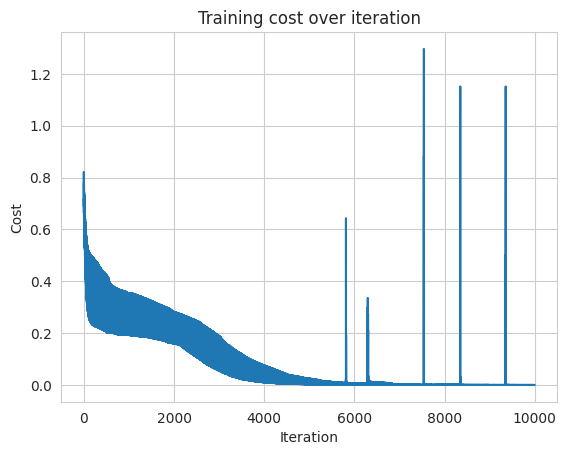

In [69]:
# Plot the costs.
plot(costs)


import doctest

"""
  >>> print(np.round(costs[0][1], 3))
  0.811
  >>> print(np.round(costs[1500][1], 3))
  0.416
  >>> print(np.round(costs[3500][1], 3))
  0.189
  >>> print(np.round(costs[15000][1], 3))
  0.272
  >>> print(np.round(costs[32000][1], 3))
  0.016
"""

In [70]:
# Get predictions on the train set.
predictions_train = rmsprop_model.predict(X_train)

# Get predictions on the test set.
predictions_test = rmsprop_model.predict(X_test)


import doctest

"""
  >>> print(predictions_train[0][17])
  1
  >>> print(predictions_train[0][50])
  1
  >>> print(predictions_test[0][1])
  1
  >>> print(predictions_test[0][6])
  0
"""

doctest.testmod()

TestResults(failed=0, attempted=4)

In [71]:
# Evaluate train accuracy.
rmsprop_model.evaluate(predictions_train, Y_train)


import doctest

"""
  >>> print(np.round(rmsprop_model.evaluate(predictions_train, Y_train), 3))
  100.0
"""

doctest.testmod()

TestResults(failed=0, attempted=1)

In [72]:
# Evaluate test accuracy.
rmsprop_model.evaluate(predictions_test, Y_test)


import doctest

"""
  >>> print(np.round(rmsprop_model.evaluate(predictions_test, Y_test), 3))
  70.0
"""

doctest.testmod()

**********************************************************************
File "__main__", line 3, in __main__
Failed example:
    print(np.round(rmsprop_model.evaluate(predictions_test, Y_test), 3))
Expected:
    70.0
Got:
    80.0
**********************************************************************
1 items had failures:
   1 of   1 in __main__
***Test Failed*** 1 failures.


TestResults(failed=1, attempted=1)

**Reflection (RMSprop vs Momentum)**
RMSprop converged faster (38s) and provided better test results than the momentum implementation, with the former having a test score of 80 and the latter 70.

### Adam  

Finally, let’s turn to the Adam algorithm. The name “Adam” is short for “Adaptive Moment Estimation”.  This algorithm combines momentum and RMSprop to try and get the benefits of both.    
As with the other algorithms, on iteration ’t’, we compute dW and db for the current minibatch. Then, we’re going to compute V_dW and V_db (the EMA of the gradients) as we did for momentum, as well as S_dW and S_db (the EMAs of the squared gradient) as we did for RMSprop.
We’re then going to implement bias correction for V_dW, V_db, S_dW, and S_db.   
- $V_{dW}=\beta_1\cdot V_{dW}+(1-\beta_1)\cdot dW$
- $V_{db}=\beta_1\cdot V_{dW}+(1-\beta_1)\cdot db$
- $S_{dW}=\beta_2\cdot S_{dW}+(1-\beta_2)\cdot dW^2$
- $S_{db}=\beta_2\cdot S_{dW}+(1-\beta_2)\cdot db^2$

We previously gave beta1 and beta2 different names, and we did this because it helps us with implementing Adam.
Remember, we used beta1 in calculations for the momentum term, and beta2 in calculations for the Rmsprop term.
The key part of the Adam algorithm comes in the update step as shown in the equations below.  
- $V_{dWcorr}=\frac{V_{dW}}{\sqrt{1-\beta_1^{\text{ } iteration}}}$
- $V_{dbcorr}=\frac{V_{db}}{\sqrt{1-\beta_1^{\text{ } iteration}}}$
- $S_{dWcorr}=\frac{S_{dW}}{\sqrt{1-\beta_2^{\text{ } iteration}}}$
- $S_{dbcorr}=\frac{S_{db}}{\sqrt{1-\beta_2^{\text{ } iteration}}}$

We’re going to update the parameters with the bias corrected EMA of the gradient divided by the square root of the bias corrected EMA of the squared gradients.
That means, for example, that we update the weights as follows:
- $W=W-\alpha\cdot \frac{V_{dWcorr}}{\sqrt{S_{dWcorr}} + \epsilon}$  

and then do the same for the biases using V_db_corr and S_db_corr:  

- $b=b-\alpha\cdot \frac{V_{dbcorr}}{\sqrt{S_{dbcorr}} + \epsilon}$

<br>

**Step 21:**   

Let’s now implement Adam in code.  Uncomment the appropriate sections in the Framework Dense class and add the code for Adam.
The Adam algorithm builds on the idea of an adaptive learning rate and combines the benefits of momentum and RMSprop. As such, it often converges faster than even RMSprop.  

As usual, begin by navigating back to the Dense class. You have already initialized all the hyperparameters you will need, so we can move on immediately to the backward() function.  

**backward():**
- After completing the if statement to check for the Adam optimizer, fill in the code to calculate V_dW, V_db, S_dW, and S_db exactly as you have done before:  
  - $V_{dW}=\beta_1\cdot V_{dW}+(1-\beta_1)\cdot dW$
  - $V_{db}=\beta_1\cdot V_{dW}+(1-\beta_1)\cdot db$
  - $S_{dW}=\beta_2\cdot S_{dW}+(1-\beta_2)\cdot dW^2$
  - $S_{db}=\beta_2\cdot S_{dW}+(1-\beta_2)\cdot db^2$  

- Then compute bias corrected values for each (see the bias equations provided above).


**update():**
- Update the weights using the bias corrected values of V_dW, V_db, S_dW, and S_db.

**Step 22-27:**  
Now we’re ready to test Adam.   

As was done with the previous two algorithms, instantiate your model and build the network with the same architecture as before. That is construct the model with 2 inputs nodes, which is equal to the shape of the planar dataset, Dense layers of 25, 50, 50, and 25 nodes each, and an output layer of 1 node. Set each layer’s activation function to ‘relu’ except for the output layer, which should be set to ‘sigmoid’.  

Fit the model to the data using 22,000 epochs and a learning rate of 0.0001 for ease of comparison with RMSprop. Use a minibatch size of 16 and set the optimizer to ‘adam’. Run the training, plot the costs, make predictions, and evaluate train and test accuracy.  

Take a look at the plotted costs. You should find the graph is broadly comparable to that of RMSprop. Since we’re working with a small, low dimensional dataset, we wouldn’t’ expect a great difference between the RMSprop and Adam algorithms in terms of performance. When you calculate the predictions you can see that Adam also converges by the 10,000th epoch, and when you evaluate the performance you’ll see this gives 100% train accuracy and 90% test accuracy.



In [92]:
# Instantiate your model.
adam_model = Model()

# Build a deep neural network.
adam_model.build([
                Dense(output_units=25, input_units=2, activation='relu'),
                Dense(output_units=50, input_units=25, activation='relu'),
                Dense(output_units=50, input_units=50, activation='relu'),
                Dense(output_units=25, input_units=50, activation='relu'),
                Dense(output_units=1, input_units=25, activation='sigmoid'),
])


In [94]:
# Use the Adam algorithm by setting the optimizer to 'adam'. Set the batch size to 16.
# Fit your model to the training data with 10000 epochs and a smaller learning_rate of 0.0001.
costs = adam_model.fit(X_train, Y_train, epochs=10000, learning_rate=0.0001, batch_size=16, optimizer='Adam')


<ipython-input-88-5e032da0e09b>:38: RuntimeWarning: overflow encountered in exp
  sigmoid= 1/(1 + np.exp(-Z))


**********************************************************************
File "__main__", line 3, in __main__
Failed example:
    print(np.round(costs[0][1], 3))
Expected:
    0.811
Got:
    0.253
**********************************************************************
File "__main__", line 5, in __main__
Failed example:
    print(np.round(costs[1500][1], 3))
Expected:
    0.412
Got:
    0.243
**********************************************************************
File "__main__", line 7, in __main__
Failed example:
    print(np.round(costs[3500][1], 3))
Expected:
    0.187
Got:
    0.132
**********************************************************************
File "__main__", line 9, in __main__
Failed example:
    print(np.round(costs[15000][1], 3))
Expected:
    0.268
Got:
    0.062
**********************************************************************
File "__main__", line 11, in __main__
Failed example:
    print(np.round(costs[32000][1], 3))
Expected:
    0.013
Got:
    0.0
************

TestResults(failed=5, attempted=5)

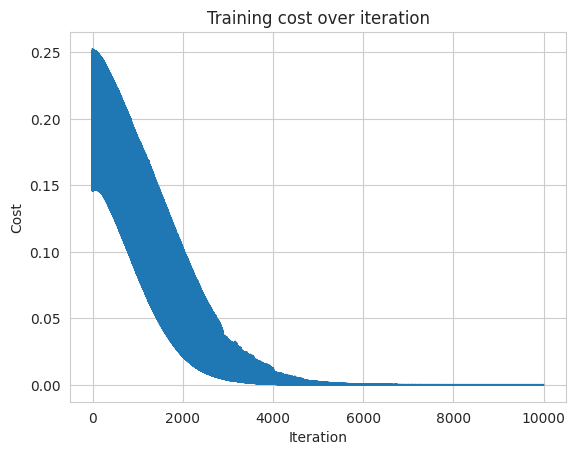

In [95]:
# Plot the costs.
plot(costs)



import doctest

"""
  >>> print(np.round(costs[0][1], 3))
  0.811
  >>> print(np.round(costs[1500][1], 3))
  0.412
  >>> print(np.round(costs[3500][1], 3))
  0.187
  >>> print(np.round(costs[15000][1], 3))
  0.268
  >>> print(np.round(costs[32000][1], 3))
  0.013
"""
doctest.testmod()


In [96]:
# Get predictions on the train set.
predictions_train = adam_model.predict(X_train)

# Get predictions on the test set.
predictions_test = adam_model.predict(X_test)



import doctest

"""
  >>> print(predictions_train[0][17])
  1
  >>> print(predictions_train[0][50])
  1
  >>> print(predictions_test[0][1])
  0
  >>> print(predictions_test[0][6])
  0
"""

doctest.testmod()

**********************************************************************
File "__main__", line 7, in __main__
Failed example:
    print(predictions_test[0][1])
Expected:
    0
Got:
    1
**********************************************************************
File "__main__", line 9, in __main__
Failed example:
    print(predictions_test[0][6])
Expected:
    0
Got:
    1
**********************************************************************
1 items had failures:
   2 of   4 in __main__
***Test Failed*** 2 failures.


TestResults(failed=2, attempted=4)

In [97]:
# Evaluate train accuracy.
adam_model.evaluate(predictions_train, Y_train)



import doctest

"""
  >>> print(np.round(adam_model.evaluate(predictions_train, Y_train), 3))
  100.0
"""

doctest.testmod()

TestResults(failed=0, attempted=1)

In [98]:
# Evaluate test accuracy.
adam_model.evaluate(predictions_test, Y_test)



import doctest

"""
  >>> print(np.round(adam_model.evaluate(predictions_test, Y_test), 3))
  80.0
"""

doctest.testmod()

**********************************************************************
File "__main__", line 3, in __main__
Failed example:
    print(np.round(adam_model.evaluate(predictions_test, Y_test), 3))
Expected:
    80.0
Got:
    90.0
**********************************************************************
1 items had failures:
   1 of   1 in __main__
***Test Failed*** 1 failures.


TestResults(failed=1, attempted=1)

WHEN YOU COMPLETE THIS SECTION - STOP, AND UPLOAD YOUR COLAB SCRIPT FOR THIS ASSIGNMENT.

**Reflection (Adam vs RMSprop)**
Other than stellar test results from the Adam algorithm, there were no major differences in performance between Adam and RMSprop. The former had the highest testing accuracy at 90%.